<a href="https://colab.research.google.com/github/dimenwarper/colab_biowrappers/blob/main/ColabQCxMS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab for *in silico* mass spectrometry via quantum and moleculary dynamic calculations

This Colab is a frontend to some of the functionality behind [QCxMS](https://xtb-docs.readthedocs.io/en/latest/qcxms_doc/qcxms.html), a method that uses quantum calculations and molecular dynamics to simulate the spectra resulting from blasting a molecule with an accelerated gas or a beam of ions. This is meant to be a bare-bones demonstration of how fairly esoteric programs can be wrapped in a colab for general exploration -- it allows a very limited number of trajectories and the molecules interrogated have to be relatively small. If you want to actually use this for something useful, take a look at the code and read the QCxMS docs.

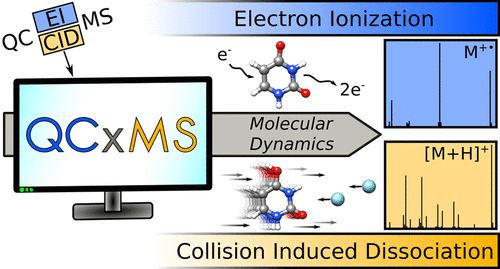

In [ ]:
SMILES = "COS(=O)(=O)OC" #@param {type:"string"}
num_trajectories = 2 #@param {type:"slider", min:0, max:10, step:1}

In [ ]:
#@title Install dependencies
import subprocess

class Setup:
  STEPS = {
      'Installing openbabel': 'apt-get install openbabel',
      'Getting QCxML': 'wget https://github.com/qcxms/QCxMS/releases/download/v.5.1.2/QCxMS.v.5.1.2.tar.xz',
      'Installing QCxML': 'mkdir -p qcxms && tar xvf QCxMS.v.5.1.2.tar.xz -C qcxms && cp qcxms/* /usr/bin/ || chmod a+x /usr/bin/getres',
      'Getting PlotMS': 'wget https://github.com/qcxms/PlotMS/releases/download/v.5.1/PlotMS.v.5.1.tar.xz',
      'Installing PlotMS': 'tar xvf PlotMS.v.5.1.tar.xz && mv plotms /usr/bin && mv .mass_raw.agr /root/',
      'Installing py3dmol': 'pip install py3dmol'
  }

  def run(self):
    for name, step in Setup.STEPS.items():
      print(f'INFO: {name}')
      try:
        out = subprocess.check_output(step, shell=True, stderr=subprocess.STDOUT)
      except subprocess.CalledProcessError as e:
        print(e)

Setup().run()

INFO: Installing openbabel
INFO: Getting QCxML
INFO: Installing QCxML
INFO: Getting PlotMS
INFO: Installing PlotMS
INFO: Installing py3dmol


In [ ]:
#@title Run QCxMS
import os
from pathlib import Path
from contextlib import contextmanager
import time

@contextmanager
def timeit(desc):
  start = time.time()
  yield
  print(f'{desc} finished in {int(time.time() - start)} seconds')


@contextmanager
def set_directory(path: Path):
  origin = Path().absolute()
  try:
    os.chdir(path)
    yield
  finally:
    os.chdir(origin)

  
def smiles_to_coord(smiles):
  ifl = 'coord.tmol'
  subprocess.check_call(['obabel', f'-:{smiles}',  '-O', ifl, '--gen3d', 'best'])
  subprocess.check_call(['obabel', ifl,  '-O', 'coord.pdb'])
  subprocess.check_call(['mv', ifl, 'coord'])

def write_qcxms_config(config):
  with open('qcxms.in', 'w') as f:
    for opt, val in config.items():
      if not val:
        f.write(f'{opt}\n') 
      else:
        f.write(f'{opt} {val}\n') 

def status_print(s):
  print("\r", s, end="")

class Commands:
  @staticmethod
  def cid(smiles, outdir, ntraj=10, **kwargs):
    os.makedirs(outdir, exist_ok=True)
    with set_directory(Path(outdir)):
      smiles_to_coord(smiles)
      write_qcxms_config(
          {
            'xtb2': '', 
            'cid': '',
            'elab': '60', 
            'lchamb': '0.25', 
            'fullauto': '', 
            'ntraj': str(ntraj),
          }
      )

      with timeit(f'QCxMS CID for {smiles}'):
        try:
          status_print('Calculating trajectories')
          subprocess.check_output(['qcxms'])
          status_print('Preparing for prod run')
          subprocess.check_output(['qcxms'])
          status_print(f'Running for {ntraj} trajectories')
          subprocess.check_output(['pqcxms'])
          status_print(f'Getting results')
          subprocess.check_output(['getres'])
          status_print(f'PlotMS for extracting spectra')
          subprocess.check_output(['plotms'])
          print('')
        except subprocess.CalledProcessError as e:
          print(e)
          print(e.output.decode('utf-8'))


Commands.cid(SMILES, 'run', ntraj=num_trajectories)

 PlotMS for extracting spectra
QCxMS CID for COS(=O)(=O)OC finished in 126 seconds


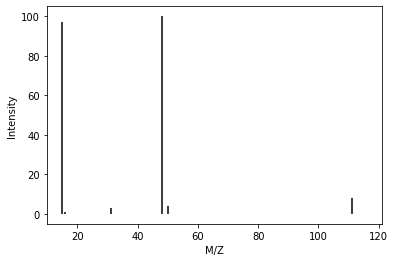

In [ ]:
#@title Plot Spectra
#@markdown 👈 After a succesful run, spectra is available for download in the left pain under `run/result.jdx`
import pandas as pd
import matplotlib.pyplot as plt

def read_spectra(jdx_file):
  spectra = []
  with open(jdx_file) as fl:
    for line in fl:
      if line[0] != '#':
        fields = line.strip().split()
        spectra.append([float(fields[0]), float(fields[-1])])
  return pd.DataFrame(spectra, columns=['mz', 'intensity'])


def plot_spectra(spectra):
  plt.vlines(spectra['mz'], 0, spectra['intensity'])
  plt.xlabel('M/Z')
  plt.ylabel('Intensity')

plot_spectra(read_spectra('run/result.jdx'))

In [ ]:
#@title View trajectories
import py3Dmol
view = py3Dmol.view(width=400, height=300)

trajectory = 1 #@param {type:"integer"} 
run = 1 #@param {type:"integer"}

def render_molecule(fname):
  with open(fname) as ifile:
      models = "".join([x for x in ifile])


  view.addModelsAsFrames(models)
  default = {"stick": {}}
  view.setStyle(default)
  view.zoomTo()
  view.show()

def render_trajectory(fname):
  with open(fname) as ifile:
      models = "".join([x for x in ifile])


  view.addModelsAsFrames(models)
  default = {"stick": {}}
  view.setStyle(default)

  view.animate({'loop': "forward"})
  view.zoomTo()
  view.show()


render_trajectory(f'run/TMPQCXMS/TMP.{trajectory}/CID{run}.xyz')

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol